# Image-Based Invasion Percoalation

This notebook illustrates the use of the image-based invasion percolation algorithm decribed [here](https://arxiv.org/abs/2101.03240).

Import necessary packages and functions

In [1]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from edt import edt
import imageio
from copy import copy

## Generate test image

In [2]:
np.random.seed(5)
im = ps.generators.blobs(shape=[500, 500], porosity=0.6, blobiness=2)

Also generate an image defining the inlets

In [3]:
bd = np.zeros_like(im, dtype=bool)
bd[:, 0] = 1
bd *= im
im = ps.filters.trim_disconnected_blobs(im=im, inlets=bd)
dt = edt(im)

## Apply IBIP to image

In [4]:
inv_seq, inv_size = ps.filters.ibip(im=im, inlets=bd, mode='morph',
                                    return_sizes=True, max_iters=15000)


No more accessible invasion sites found...exiting


## Do some post-processing 

Convert invasion sequence values to saturation, and identify trapped regions:

In [5]:
inv_satn = ps.filters.seq_to_satn(seq=inv_seq)
inv_seq_trapping = ps.filters.find_trapped_regions(seq=inv_seq, bins=None,
                                                   return_mask=False)
inv_satn_trapping = ps.filters.seq_to_satn(seq=inv_seq_trapping)

## Run standard MIO for comparison:

Compute the MIO result, convert to sequation and saturation using the functions in ``porespy.tools``, and also find trapped regions.

In [6]:
sizes = np.arange(int(dt.max())+1, 0, -1)
mio = ps.filters.porosimetry(im=im, inlets=bd, sizes=sizes, mode='mio')
mio_seq = ps.filters.size_to_seq(mio)
mio_seq[im*(mio_seq == 0)] = -1  # Adjust to set uninvaded to -1
mio_satn = ps.filters.seq_to_satn(mio_seq)
mio_seq_trapping = ps.filters.find_trapped_regions(seq=mio_seq, bins=None,
                                                   return_mask=False)

Comparing the invasion configurations between the MIO and IBIP algorithms below suggests that the methods produce similar results when trapping is turned off.  In fact, it can be shown that the MIO result is a subset of the IBIP result.

## Compare MIO and IBIP at Equal Saturations

The comparison between the two methods can only be done when trapping is neglected.  The difference in the trapped defending phase from each method is discussed further below.  

The images below show the saturation fields for both IBIP and MIO.

> Saturation field means that each voxel in the image contains the value of the saturation at the point is was invaded.  In other words, the operation ``satn <= s`` will yeild and image containing the fluid configuration at saturation equal to ``s``.

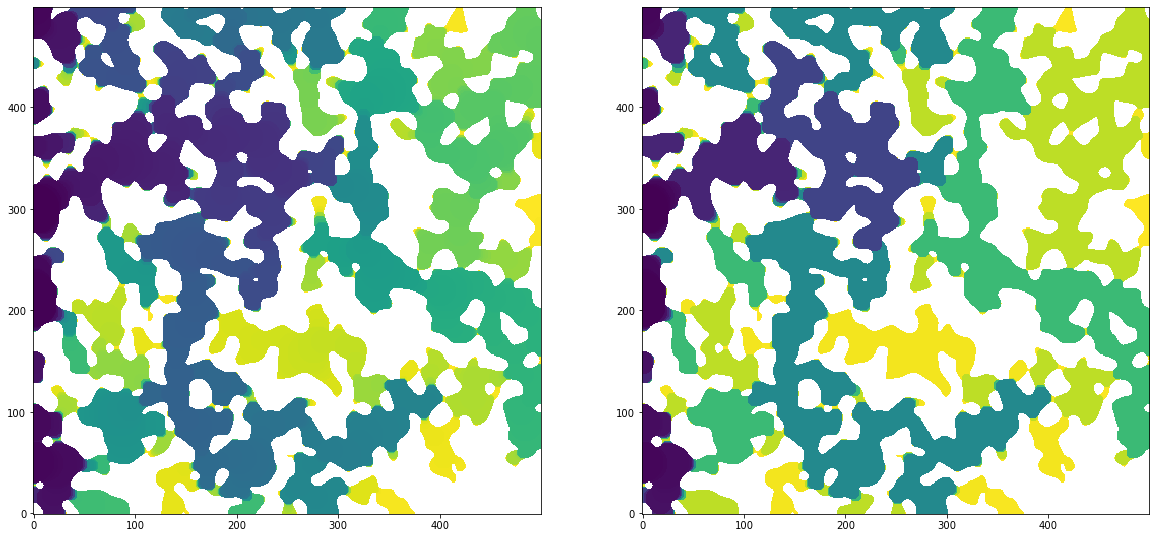

In [7]:
fig, ax = plt.subplots(1, 2, figsize=[20, 10])
ax[0].imshow(inv_satn/im, origin='lower', interpolation='none')
ax[1].imshow(mio_satn/im, origin='lower', interpolation='none')

The saturation fields can be compared directly by seeing which voxels are filled at each saturation in both methods.  We must first find all the values of saturation that were obtained in the MIO result, which consists of discrete jumps (i.e. from ``s=0.33`` to ``s=0.49``) due to the pressure based nature of the simulations.  Once we have a list of all unique saturation values, we can threshold the saturation fields from both simulations at these values and compare the configurations.

In [8]:
inv_satn_t = np.around(inv_satn, decimals=4)
mio_satn_t = np.around(mio_satn, decimals=4)
satns = np.unique(mio_satn_t)[1:]
err = []
diff = np.zeros_like(im, dtype=float)
for s in satns:
    ip_mask = (inv_satn_t <= s) * (inv_satn_t > 0)
    mio_mask = (mio_satn_t <= s) * (mio_satn_t > 0)
    diff[(mio_mask == 1)*(ip_mask == 0)*(im == 1)] = 1
    diff[(mio_mask == 0)*(ip_mask == 1)*(im == 1)] = -1
    err.append((mio_mask != ip_mask).sum())

In the figure below we plot the differences between the two results at equal saturation. On the left is the fluid configurations of each method overlaid on top of each other.  Any voxels that are not green indicate locations where the two results disagree.  There are very few of them and almost impossible to see (e.g. near [x, y]=[250, 50]), so the plot on the right shows the count of mis-matching voxels as a function of saturation.  The total count never exceeds 70, which is a very small fraction of a 500 x 500 image.  The differences are due to the numerical precision of the saturation values.

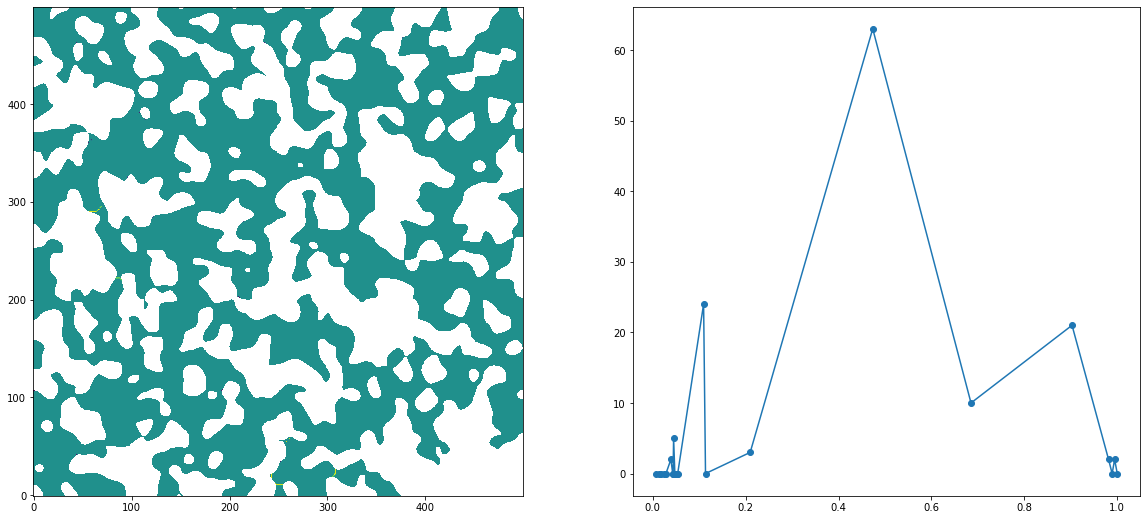

In [9]:
fig, ax = plt.subplots(1, 2, figsize=[20, 9])
ax[0].imshow(diff/im, origin='lower')
ax[1].plot(satns, err, 'o-')

## Comparing Capillary Pressure Curves

Converting the invasion configurations to capillary pressure curves is possible using functions provided in the ``metrics`` module. 


In [10]:
d = ps.metrics.pc_curve_from_ibip(im=im, seq=inv_seq, sizes=inv_size, voxel_size=1e-5)
e = ps.metrics.pc_curve_from_mio(im=im, sizes=mio, voxel_size=1e-5, stepped=True)

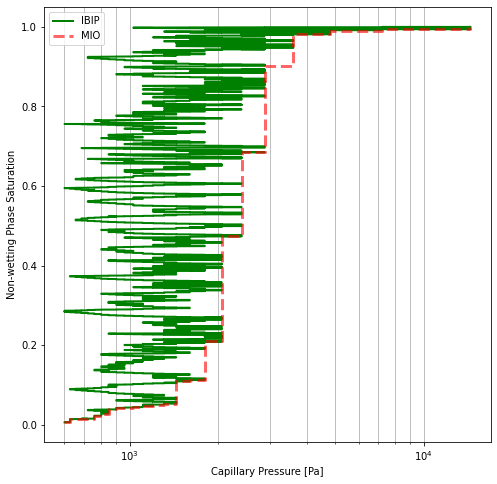

In [11]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.semilogx(np.array(d.pc), d.snwp, 'g-', linewidth=2, label='IBIP')
ax.semilogx(np.array(e.pc), e.snwp, 'r--', markersize=20, linewidth=3, alpha=0.6, label='MIO')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation')
plt.legend()
ax.xaxis.grid(True, which='both')

The above capillary pressure curves are quite interesting. The MIO curve in red is the envelop of peak pressures obtained by the IPIP curve in green. 

The red line corresponds to the normal 'porosimetry' experiment where increasingly high pressures are applied (x-axis) and larger fractions of the void space are filled (y-axis).  Each verticle jump in the red curve corresponds to a new region of the image being penetrated because the breakthrough pressure of a constriction was exceed.  All the void space beyond this constriction is then filled at once.  

The green line is the result of IBIP and corresponds to volume controlled injection, where fluid is injected at some constant rate.  Every data point has a slightly higher saturation than the previous so there are no plateaus of constant saturation.  However, the capillary pressure (x-axis) fluctuates up and down seemlingly randomly.  This is because the advancing menisci squeeze through small constrictions (higher pressure), then enter into a larger region that was sheilded by the constriction to they expand (lower pressure).  This process repeats itself through the entire simulation.  

## Compare results with trapping

One of the key benefits of the IBIP algorithm is that the fluid invades incrememtally instead of in steps.  This means the appearance of trapped defending phase is immediately noted.  By contrast, the MIO approach computes large changes in saturation, so any trapping that may occur between these large jumps is not resolved.  Therefore, only the IBIP method can correctly identify trapped defending phase.  This is illustrated below:

(-0.5, 499.5, -0.5, 499.5)

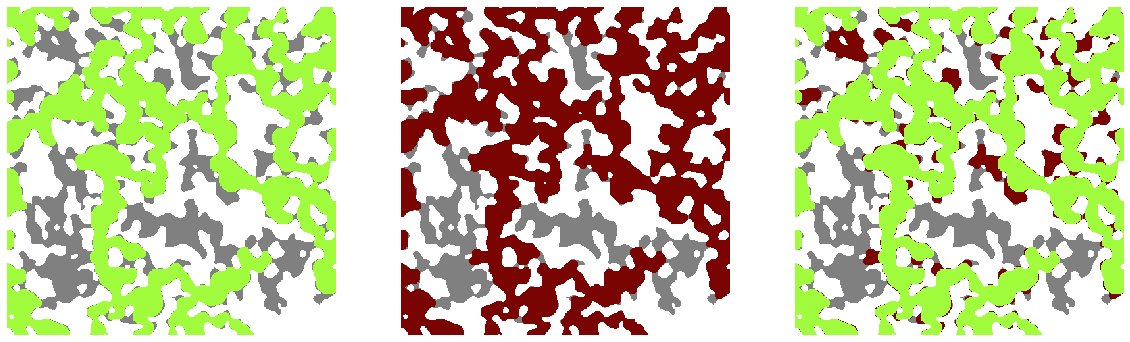

In [12]:
cmap = copy(plt.cm.turbo)
cmap.set_over(color='white')
cmap.set_under(color='grey')
fig, ax = plt.subplots(1, 3, figsize=[20, 10])
ax[0].imshow((inv_seq_trapping > 0)/im, vmin=1e-3, vmax=2,
             cmap=cmap, origin='lower', interpolation='none')
ax[0].axis('off')
ax[1].imshow((mio_seq_trapping > 0)/im, vmin=1e-3, vmax=1,
             cmap=cmap, origin='lower', interpolation='none')
ax[1].axis('off')
temp = (mio_seq_trapping > 0)*2.0 - (inv_seq_trapping > 0)*1.0
ax[2].imshow(temp/im, vmin=1e-3, vmax=2.0, 
             cmap=cmap, origin='lower', interpolation='none')
ax[2].axis('off')

The red color in the right image indicates regions that were invaded by the MIO algorithm, but not by the IBIP algorithm. The MIO will always underestimate trapping.

## Make a movie of the invasion

The image below is a sample of the animated output:

![](https://cdn.substack.com/image/fetch/w_1456,c_limit,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Ffdfb8881-2e28-410f-a36b-e0bcb906629b_500x501.gif)

Obtaining a movie such as the one above can be accomplished with something like the following, which creates an interactive widget in a jupyter notebook.

```python
from IPython.display import HTML
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 100.0
plt.rcParams["figure.dpi"] = 150
mov = ps.visualization.satn_to_movie(im=im, satn=inv_satn)
```